# AngriBERT Results Analysis
This notebook analyzes the results obtained from final runs of the models.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import json 
import re 
import numpy as np
import pandas as pd

from pathlib import Path 

from collections import Counter 

import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

sns.set()

In [15]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

## Uility functions for analysis

In [16]:
def load_results_file(filepath,remap_names={}):
    ''' Loads results file from the path specified and returns a dataframe
        Args:
        filepath: str
            Either file name or folder name. If filepath is a folder, 
        all files with *.csv patten are included in the dataframe
        remap_names: dict
            Optional Dictionary to remap experiment names. As an example, while running experiments, we could have named as TARGET, but for reporting, we would like to use the term TALES to represent the dataset. Then remap_names = {'TARGET':'TALES'} will remap all TARGET experiments to TALES

        Returns:
        dataframe
        Containing all the fields in the input files
    '''
    dfl = []
    if os.path.isdir(filepath):
        all_files = list(Path(filepath).glob('*.csv'))
        for f in all_files:
            df_sub = pd.read_csv(f)
            dfl.append(df_sub)
    else:
        df_sub = pd.read_csv(f)
        dfl.append(df_sub)

    df = pd.concat(dfl)
    df = df.reset_index()
    for map_from,map_to in remap_names.items():
        df.loc[df['name'] == map_from,'name'] = map_to
    return df 

In [17]:
def generate_report_df(df,baseline='BASELINE'):
    '''
        Takes a raw DataFrame and converts to Dataframe suitable for generating reports.
        Performs the following conversions:
        1) Carries forward the validation loss, and training performance metrics from the last epoch
        2) Calculates the total training time for all epocs and includes as train_time_total
        3) Above 2 are included with the test records, so that test and train can be compared
        4) Filters the data set for test epochs only, and selects columns required for training

        Args:
        df : DataFrame
            Dataframe from results. Typically loaded by load_results_file function
        baseline: str
            Experiment name that should be considered as baseline
        
        Returns:
        dataframe - contains only test epoch with data from corresponding training runs
        names: list
        List of experiment names without the baseline.
    '''
    # Columns that should be carried forward from Last Epoch of training 
    col_train = ['f1_train_weighted',
                 'f1_train_micro',
                 'f1_train_macro',
                 'f1_train_samples',
                 'train_val_loss']
    col_from = ['weighted','micro','macro','samples','val_loss']
    # Populate the value from original columns
    df[col_train] = df[col_from]
    # Then force the test and tr_predict to None. 
    # This will allow us to forward fill the values from the train runs
    df.loc[(df.epoch == 'test') | (df.epoch == 'tr_predict'),col_train] = None 

    # For zero-Shot predictions, we won't have a train_corpus, but we don't want to forward fill other epoch, so force them to zero.
    col_ffill = col_train + ['train_loss','train_count','val_count']
    df.loc[(df.epoch == 'test') & (df.train_corpus.isna()),col_ffill] = 0 
    df.loc[df.name.isna(),'name'] = baseline
    #Forward fill the results
    df[col_ffill] = df[col_ffill].fillna(method='ffill')

    #All training epochs are numeric, so sum the training times for those
    df_train = df[df.epoch < 'a']
    df_trtime = df_train.groupby(['experiment']).agg({'train_time':['sum']}).reset_index(level=0)
    df_trtime.columns = ['experiment','train_time_total']
    # Populate the total training time against each record
    df_test = df.merge(df_trtime,how='left',on='experiment').reset_index(level=0)

    #Now we have all relevant train data mapped to corresponding test record, so filter for just test
    df_test = df_test[df_test.epoch == 'test']
    col_out = ['name','experiment','train_count','weighted','micro','macro','samples','val_loss','val_time','train_time_total','outputs','targets'] + col_train

    df_rep = df_test[col_out]
    names = list(df_rep['name'].unique())
    names.remove(baseline)
    return df_rep, names 

In [18]:
def evaluate(df_rep,names,metric,topmodels=3,
            compare_to='TALES',index='train_count',columns='name',aggfunc='mean'):
    ''' Evaluates the dataframe, calculates difference on metric against the compare_to
        Topmodels are determined by the models that have maximum number of positive gains 
        over the compare_to column
        Args:
        df_rep : DataFrame 
            Typically the output of generate_report_df
        names: list
            List of experiment names to evaluate. Should typically exclude the compare_to column
        metric: str
            Metric to compare. Must be numeric column in df_rep
        topmodels: int
            Number of top models to returns
        compare_to: str
            Experiment that metric should be compared to.
        index: str (default: train_count)
            Field to report by. Typically should always be default
        columns: str (default: name )
            Column to pivot by. Only provided in case column name is changed in df_rep
        aggfunc: str (default: mean)
            Function to use for pivot
        
        Returns:
        DataFrame: pivoted dataframe by metric, including the difference from the compare_to column
        dict: Top Models containing the number of points that have better performance than compare_to column.
    '''
    df_pivot = df_rep.pivot_table(metric,index=index,columns=columns,aggfunc=aggfunc)
    diff_names = ['diff_' + name for name in names]
    for name in names:
        df_pivot['diff_'+name] = df_pivot[name] - df_pivot[compare_to]
    
    df_diff = df_pivot[diff_names]

    #Find the top models by summing up the positive differences
    arr = df_pivot[diff_names].to_numpy()

    arr_positive = np.sum(arr >= 0,axis=0)
    top_models = np.flip(np.argsort(arr_positive))
    # print ('top_models\n',top_models)
    topn = {names[k]:arr_positive[k] for k in top_models[:topmodels]}
    return df_pivot, topn


In [19]:
def show_graphs(df_rep,names,metric,compare_to=['TALES'],axes=None,ylabel='F1-Micro'):
    '''
        Displays one graph for each experiment in names, for the selected metric
        Args:
        df_rep : DataFrame 
            Typically the output of generate_report_df
        names: list, dict
            List of Experiment names to generate line graphs for. 
            Alternatively topn dictionary for evaluate can be passed directly.
            One graph is generated for each name in names
        metric: str
            Metric to plot. Must be a numeric column in df_rep
        compare_to: list
            List of additional columns to include in the graph
        axes : matplotlib.axes
            Axes to use. By default new axes are created for the graph. 
        ylabel: Label to use for y-axis

        Returns

    '''
    topnlist = names
    if isinstance(names,dict):
        topnlist = list(names.keys())
    if isinstance(compare_to,str):
        compare_to = [compare_to]
    for name in topnlist:
        models = [name] + compare_to
        df_subl = [df_rep[df_rep.name == m] for m in models]
        df_sub = pd.concat(df_subl)
        plt.figure(figsize=(10,10))
        sns.set_style("whitegrid")
        ax = sns.lineplot(data=df_sub, 
                    x="train_count", 
                    y=metric,
                    hue = 'name',hue_order=models,
                    style='name',style_order =models,
                    markers=True,
                    ax = axes,
                    palette='tab10')
        ax.set_xlabel('Training samples from Tales')
        ax.set_ylabel(ylabel)
        ax.legend(loc = "upper left",prop={'size': 12})
        if not axes:
            plt.show()

In [20]:
def write_tex(df_pivot,topnkeys,metric,path='./data/results',prefix='top',baseline='TALES'):
    '''
        Outputs LATEX table from df_pivot comparing metric. One table is generated for each experiment in topnkeys
        Args
        df_pivot: DataFrame
            Pivot table containing metric and its differences. Must be generated by evaluate function above.
        topnkeys: list, dict
            List of Experiment names to generate line graphs for. 
            Alternatively topn dictionary for evaluate can be passed directly.
            One table is generated for each key in topnkey
        metric: str
            Must be a numeric column in df_pivot. Metric should be the same as passed to evaluate
        path: str
            Path where LaTex files should be written
        prefix: str
            Prefix to use for each file. File names are automatically generated as
            Prefix_metric_<seq>_<experiment>
        baseline: str
            Column to use as baseline / compare to column. Must the same column passed to evaluate
        
        Returns: None
        All output is written to path specified

    '''
    topnlist = topnkeys
    if isinstance(topnkeys,dict):
        topnlist = list(topn.keys())
    for i,k in enumerate(topnlist):
        col_names = [baseline,k,'diff_' + k]
        df_pivot.to_latex(path + '/{}_{}_{}_{}.tex'.format(prefix,metric,i+1,k), 
                   columns=col_names,
                   float_format='{:0.4f}'.format,
                   bold_rows=True)

In [21]:
def get_confusion_matrix(df_rep,names=None,
        labels=['joy','anger','digust','fear','sadness','surprise','noemo']):
    '''
        Generates a Confusion Matrix from df_rep for the experiments specified in names
        Args:
        df_rep: DataFrame
            DataFrame typically output of generate_report_df
        names: list
            List of experiments to include
        labels: list
            Labels for emotions evaluated in the df_rep. Must match the matrix length in outputs and targets columns
        
        Returns:
        DataFrame: containing each experiment as index, and each emotion as column. Values contain the confusion matrix for the experiment and emotion.
    '''
    cm_dict = {l:{} for l in labels}
    if not names:
        names = df_rep.name.unique()
    # print (df_rep.columns) 
    out_col = df_rep.columns.get_loc('outputs')
    tgt_col = df_rep.columns.get_loc('targets')
    # print (out_col,tgt_col)
    for name in names:
        dfo = df_rep[df_rep.name == name]
        output = json.loads(dfo.iloc[0,out_col])
        target = json.loads(dfo.iloc[0,tgt_col])

        cm = multilabel_confusion_matrix(target,output)
        # print (cm.shape)
        for i in range(cm.shape[0]):
            cm_dict[labels[i]][name] = cm[i]
    dfcm = pd.DataFrame(cm_dict)
    return dfcm

## Main routines for analysis
### Generate the Performance metrics
Calculate the difference in F1-micro metric from the TARGET of TALES. Generate graphs for and LaTex tables to include in report. Graphs are generated in order of best performance

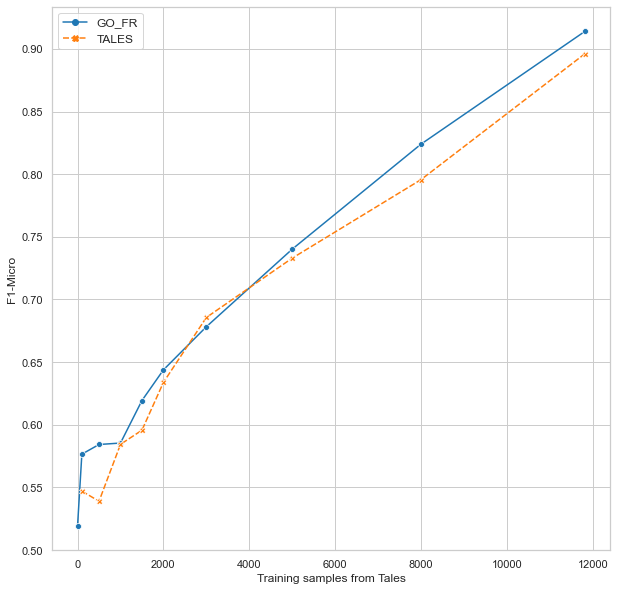

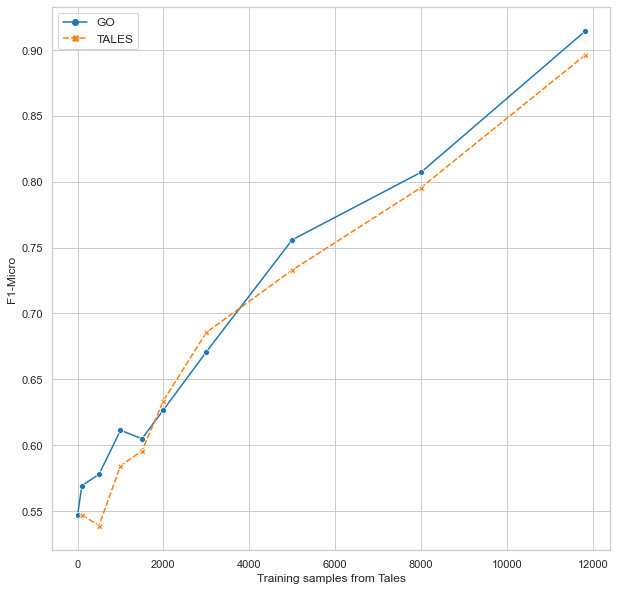

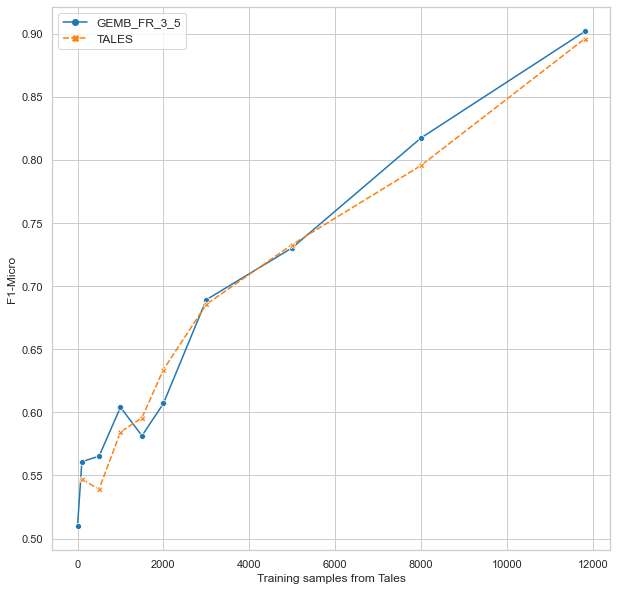

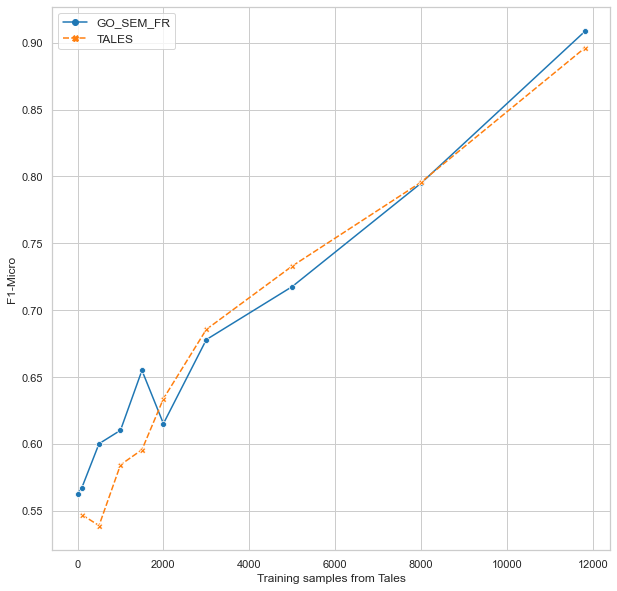

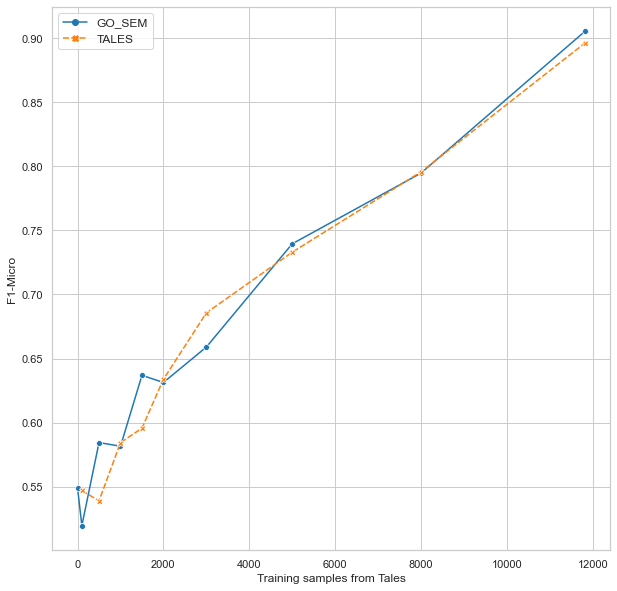

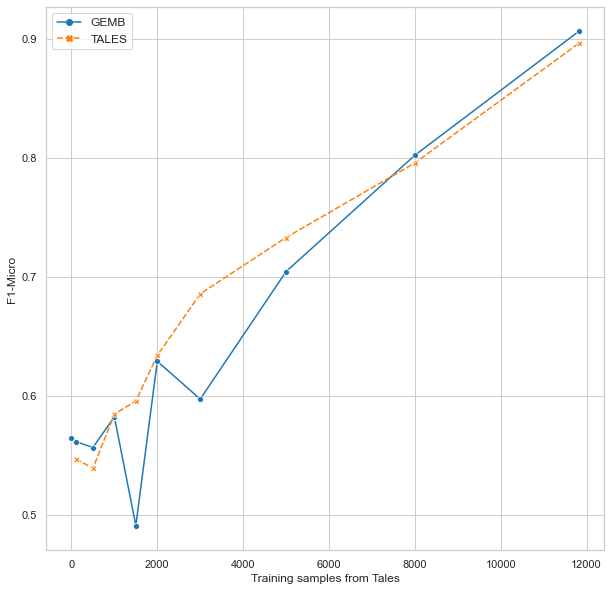

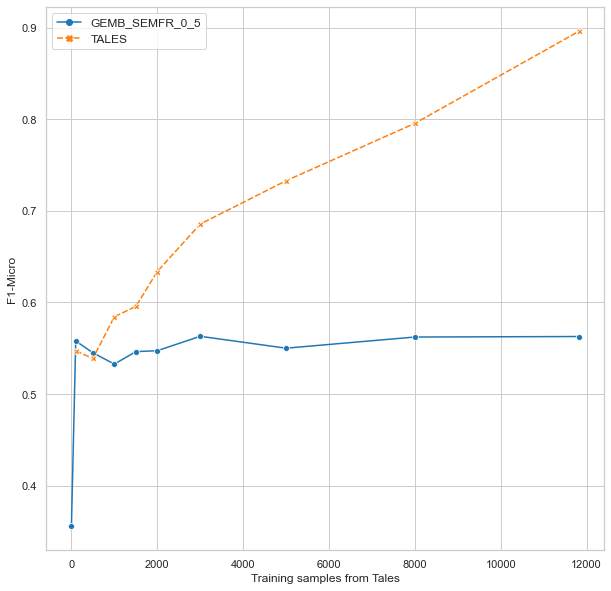

In [22]:
metric = 'micro'

df = load_results_file('./data/finalresults',
             {'GEMB_SEM_FR_0_5':'GEMB_SEMFR_0_5',
              'TARGET':'TALES'
             })

df_rep, names = generate_report_df(df.copy(),baseline='TALES')
df_pivot, topn = evaluate(df_rep,names,metric,compare_to='TALES',topmodels=8)

write_tex(df_pivot,topn,metric,prefix='top',baseline='TALES')
show_graphs(df_rep,topn,metric,compare_to='TALES')


### Generate consolidate graphs for all models

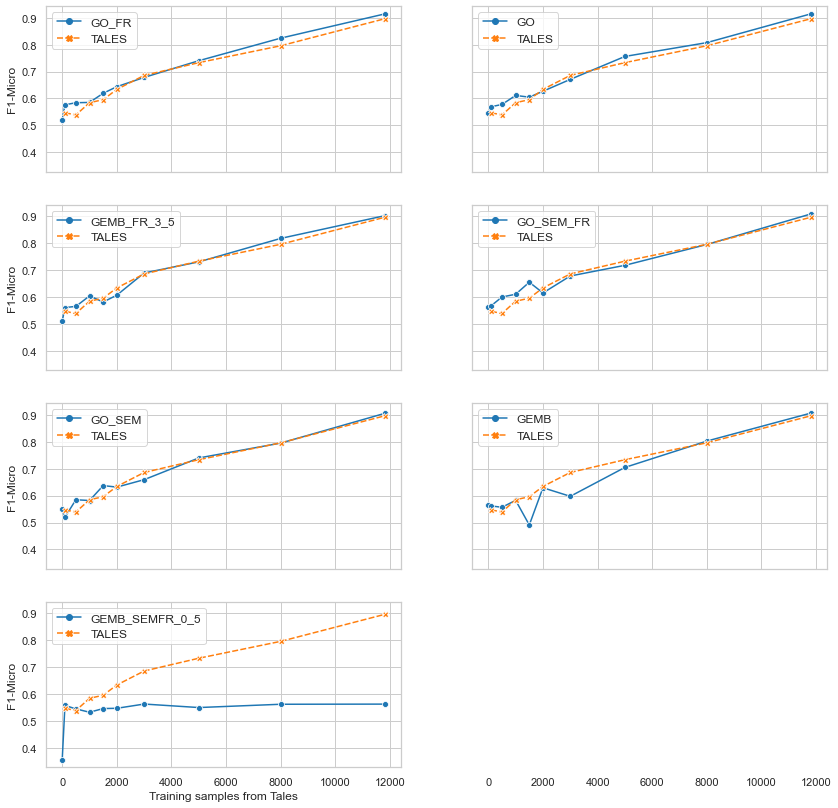

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [23]:
fig,ax = plt.subplots(4,2,sharex=True,sharey=True, squeeze=True,figsize=(14,14))
# We have only 7 experiments, turn off the axis for last graph
ax[-1,-1].grid(False)
ax[-1,-1].get_yaxis().set_visible(False)
ax[-1,-1].set_frame_on(False)
ax[-1,-1].get_xaxis().set_visible(True)
for axes,name in zip(ax.flatten(),topn.keys()):
    if name:
        show_graphs(df_rep,[name],metric,compare_to=['TALES'],axes=axes)
plt.show()

### Compare the GO alone vs combined
Compare performance of each metric with TARGET and also check the advantages, if any in combining GoEmotions with other corpus.

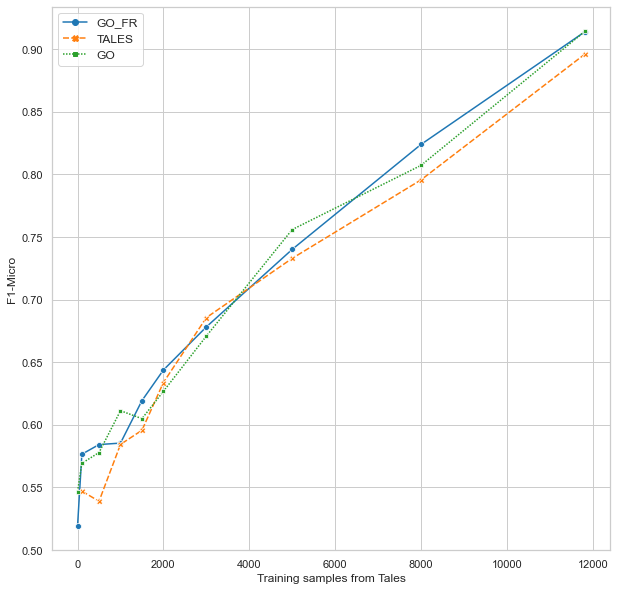

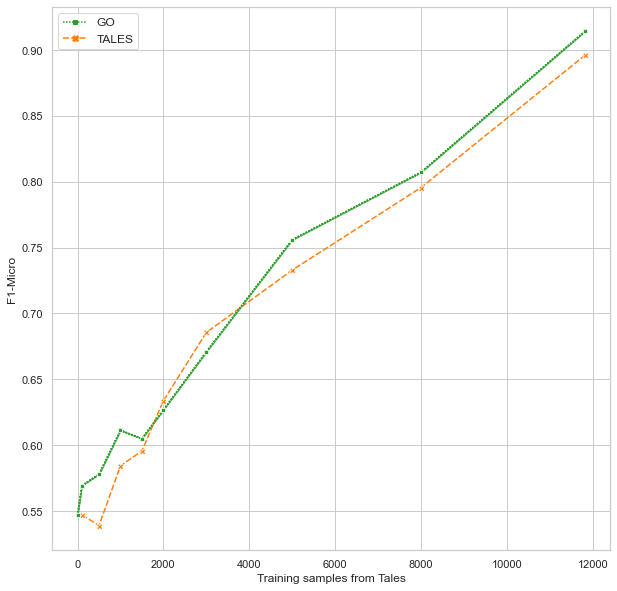

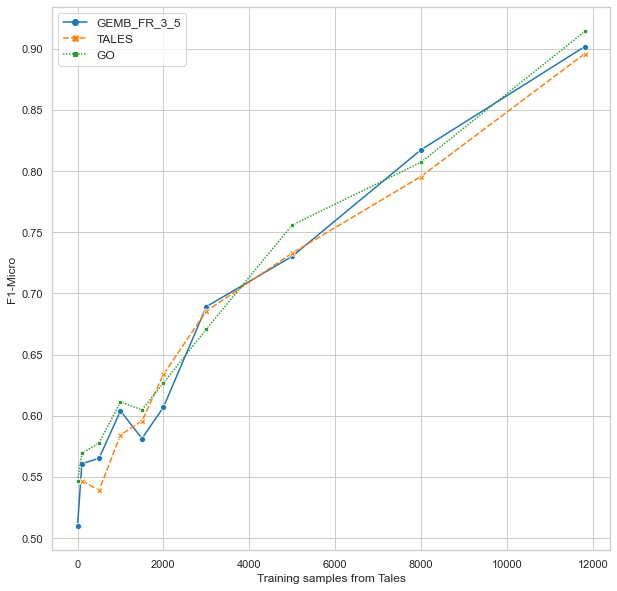

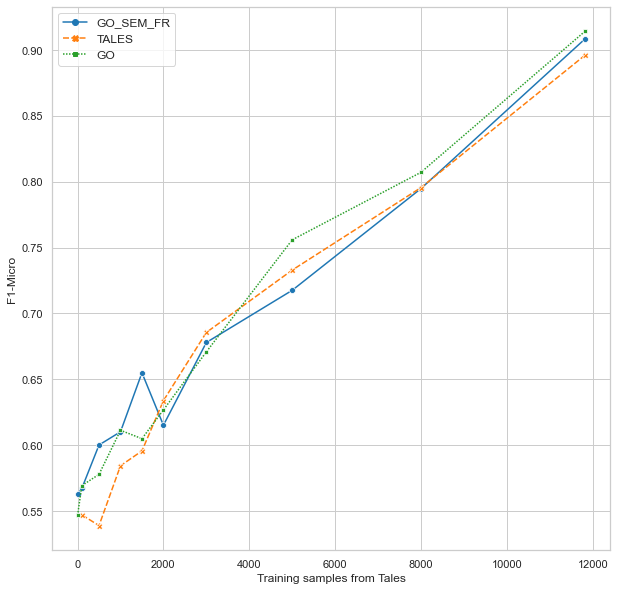

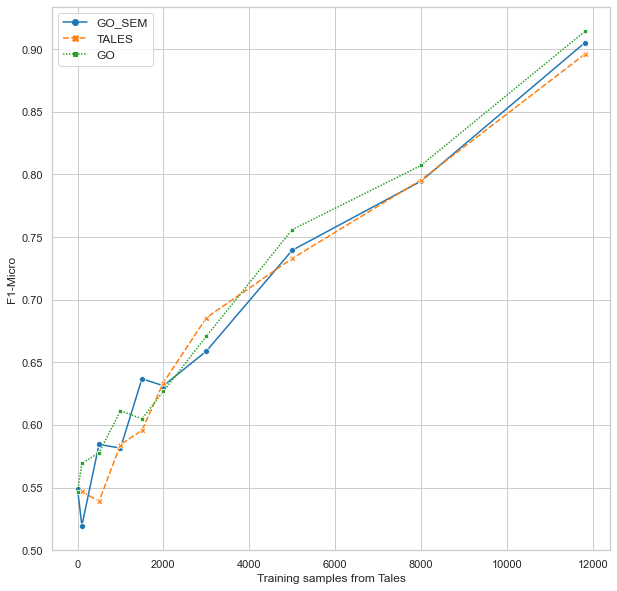

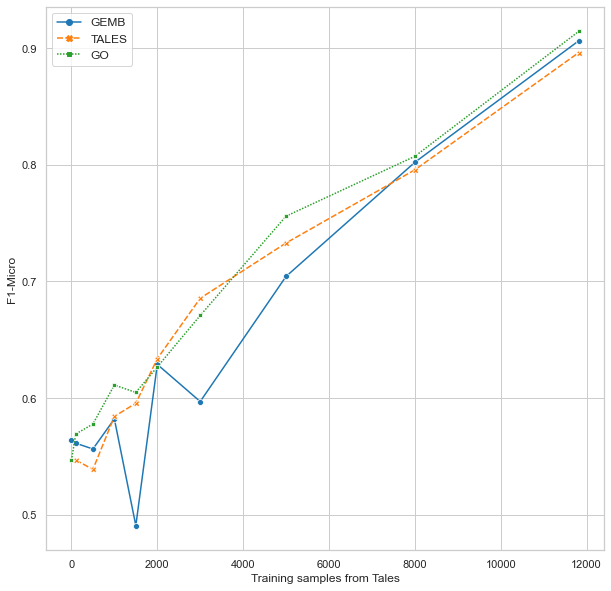

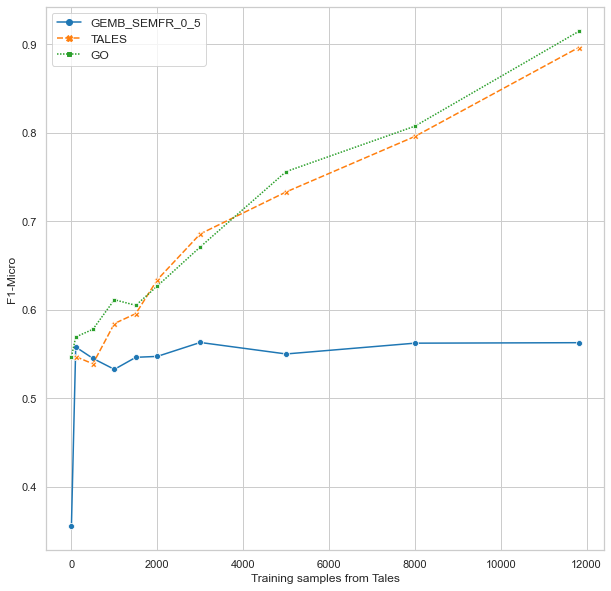

In [24]:
show_graphs(df_rep,topn,metric,compare_to=['TALES','GO'])

### Compare training times 
Compare training times across models

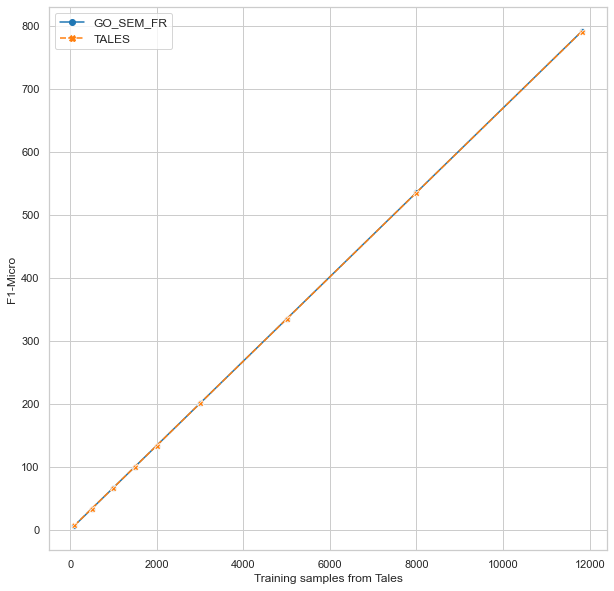

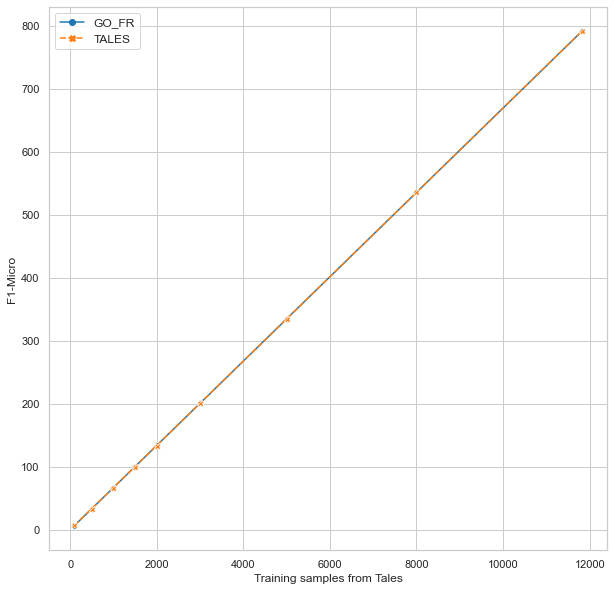

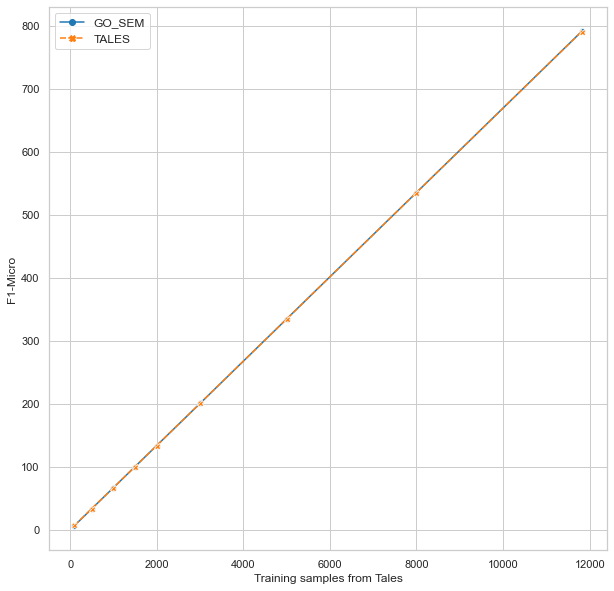

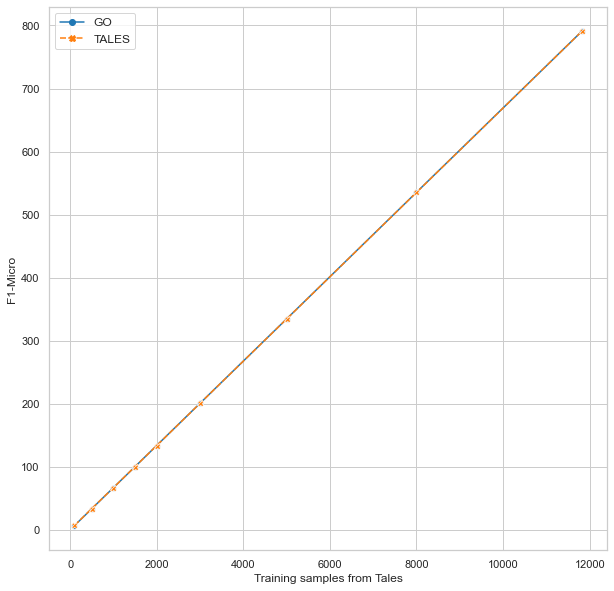

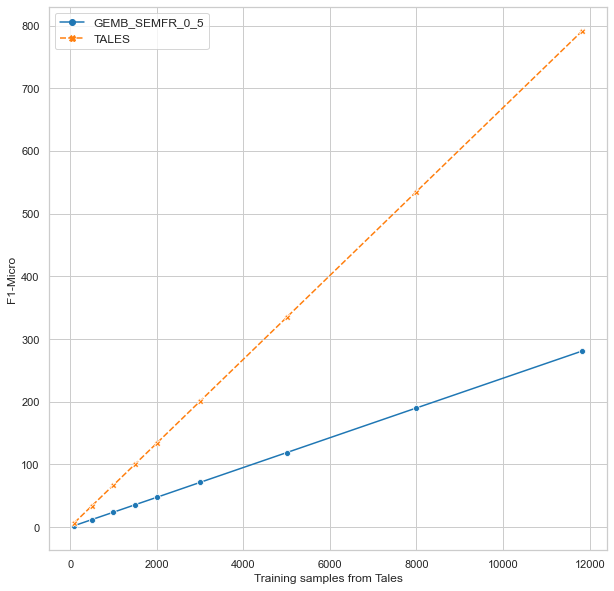

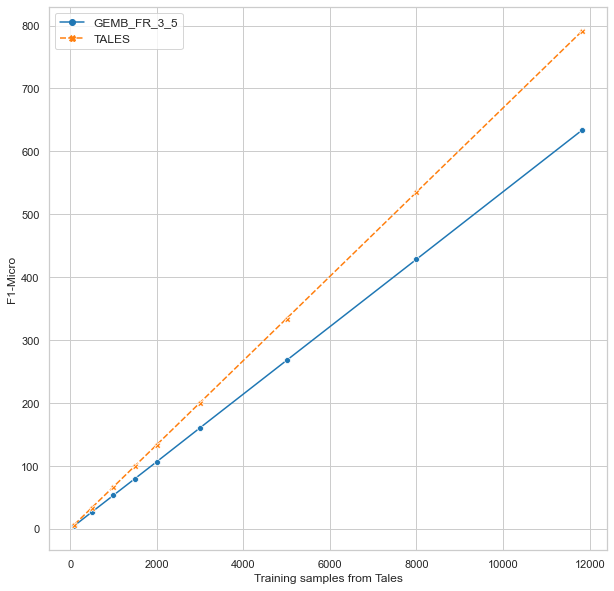

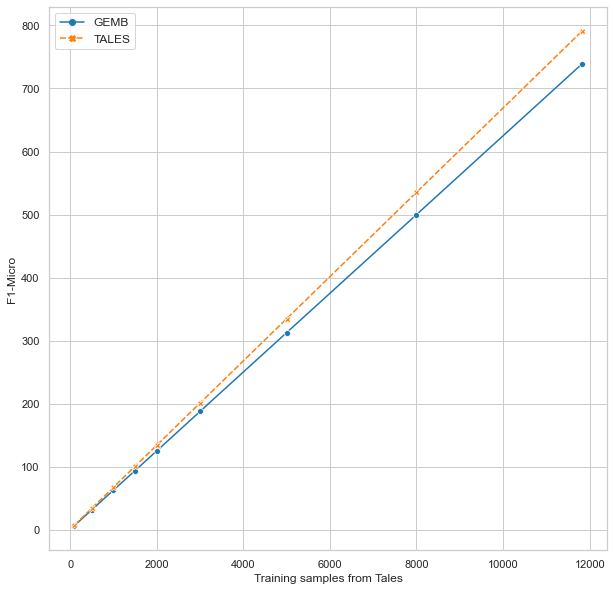

In [25]:
metric = 'train_time_total'
df_pivot, topn = evaluate(df_rep,names,metric,compare_to='TALES',topmodels=8)

write_tex(df_pivot,topn,metric,prefix='train',baseline='TALES')
show_graphs(df_rep,topn,metric,compare_to='TALES')

### Generate Confusion Matrix
Evaluate the confusion matrix for each label and experiment

In [26]:
dfcm = get_confusion_matrix(df_rep[df_rep.train_count > 10000])
dfcm

,joy,anger,digust,fear,sadness,surprise,noemo
GEMB,"[[1244, 20], [28, 185]]","[[1330, 3], [23, 121]]","[[1452, 4], [8, 13]]","[[1375, 9], [27, 66]]","[[1332, 13], [13, 119]]","[[1394, 17], [17, 49]]","[[615, 54], [38, 770]]"
GEMB_FR_3_5,"[[1238, 26], [26, 187]]","[[1322, 11], [19, 125]]","[[1451, 5], [9, 12]]","[[1379, 5], [25, 68]]","[[1340, 5], [18, 114]]","[[1404, 7], [22, 44]]","[[605, 64], [44, 764]]"
GEMB_SEMFR_0_5,"[[1257, 7], [192, 21]]","[[1331, 2], [139, 5]]","[[1456, 0], [21, 0]]","[[1378, 6], [79, 14]]","[[1343, 2], [125, 7]]","[[1411, 0], [66, 0]]","[[263, 406], [111, 697]]"
GO,"[[1247, 17], [27, 186]]","[[1331, 2], [25, 119]]","[[1442, 14], [4, 17]]","[[1379, 5], [21, 72]]","[[1341, 4], [19, 113]]","[[1398, 13], [14, 52]]","[[606, 63], [24, 784]]"
GO_FR,"[[1240, 24], [30, 183]]","[[1322, 11], [15, 129]]","[[1456, 0], [7, 14]]","[[1379, 5], [15, 78]]","[[1331, 14], [14, 118]]","[[1403, 8], [15, 51]]","[[618, 51], [43, 765]]"
GO_SEM,"[[1248, 16], [27, 186]]","[[1329, 4], [27, 117]]","[[1452, 4], [6, 15]]","[[1357, 27], [14, 79]]","[[1323, 22], [10, 122]]","[[1408, 3], [20, 46]]","[[611, 58], [41, 767]]"
GO_SEM_FR,"[[1242, 22], [26, 187]]","[[1332, 1], [27, 117]]","[[1455, 1], [7, 14]]","[[1367, 17], [18, 75]]","[[1330, 15], [12, 120]]","[[1403, 8], [15, 51]]","[[613, 56], [43, 765]]"
TALES,"[[1246, 18], [31, 182]]","[[1327, 6], [25, 119]]","[[1456, 0], [16, 5]]","[[1371, 13], [22, 71]]","[[1326, 19], [18, 114]]","[[1393, 18], [18, 48]]","[[627, 42], [54, 754]]"


In [397]:
df_words = pd.DataFrame(words)
with pd.option_context("max_colwidth", 1000):
    print (df_words.to_latex('./data/results/topwords.tex'))

None


In [141]:
def get_summary(f,sep='\t'):
    df = pd.read_csv(f,sep=sep)
    label_cols = df.columns[1:]
    df['multi_label'] = df[label_cols].sum(axis=1)
    df['multi_label'] = df['multi_label'].apply(lambda x: 1 if x > 1 else 0)
    df['total_count'] = 1
    num_cols = df.columns[1:]
    df_sum = df[num_cols].sum(axis=0)
    return df_sum.to_dict()



In [142]:
all_train = {}
all_train['GO'] = get_summary('./data/final_ekman/goemotions_train.tsv')
all_train['SEM'] = get_summary('./data/final_ekman/semeval_train.tsv')
all_train['FR'] = get_summary('./data/final_ekman/friends_train.tsv')
all_train['TALES'] = get_summary('./data/final_ekman/tales_train.tsv')
df_summ = pd.DataFrame(all_train)

In [143]:
df_summ

,GO,SEM,FR,TALES
joy,19325,3386,1698,1465
anger,5579,2544,960,575
disgust,2328,2602,594,308
fear,726,1242,424,554
sadness,1864,2266,618,724
surprise,3469,361,1846,639
neemo,14219,0,5823,7552
multi_label,3968,3901,1246,0
total_count,43410,6838,10561,11817


<AxesSubplot:>

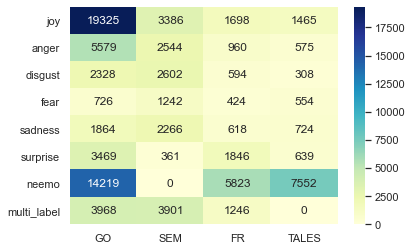

In [158]:
sns.heatmap(data=df_summ[df_summ.index != 'total_count'], annot=True, cmap='YlGnBu', fmt='d')

In [148]:
all_dev = {}
all_dev['GO'] = get_summary('./data/final_ekman/goemotions_dev.tsv')
all_dev['SEM'] = get_summary('./data/final_ekman/semeval_dev.tsv')
all_dev['FR'] = get_summary('./data/final_ekman/friends_dev.tsv')
all_dev['TALES'] = get_summary('./data/final_ekman/tales_dev.tsv')
df_dev = pd.DataFrame(all_dev)

In [149]:
df_dev

,GO,SEM,FR,TALES
joy,2434,489,167,234
anger,717,315,129,133
disgust,289,319,65,18
fear,105,121,64,119
sadness,212,292,92,137
surprise,398,35,213,99
neemo,1766,0,593,737
multi_label,478,478,124,0
total_count,5426,886,1178,1477
